# DDPLKO Moduł 9 - praca domowa - Self-Supervised Learning

To dziewiąta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Wykonanie treningu SSL z wykorzystaniem jednej z metod, wybierz framework i metodę dowolnie
- [ ] dla zbioru danych STL10:
  - [ ] Trening SSL na unlabelled, 100k zdjęć
  - [ ] Trening od zera na zbiorze train, 5k zdjęć
  - [ ] Trening transfer learning modelu z SSL na zbiorze train, 5k zdjęć
- [ ] Udostępnij wykres z porównaniem wyników validation accuracy na Discordzie `#klasyfikacja-wyniki`


# STL10

Ten zbiór wygodnie wczytasz w TensorFlow jak i w PyTorchu, linki poniżej:

- Strona zbioru: https://cs.stanford.edu/~acoates/stl10/
- PyTorch Torchvision dataset: https://pytorch.org/vision/stable/datasets.html#stl10
- TensorFlow dataset:https://www.tensorflow.org/datasets/catalog/stl10

![STL10](https://cs.stanford.edu/~acoates/stl10/images.png)


W przypadku problemów z wielkością tego zbioru:
- możesz pracować na rozdzielczości np. 32x32px
- możesz ograniczyć wielkość zbioru unlabelled (ale lepiej zmniejsz rozdzielczość)

Extra - dodatkowo możesz:
- przeprowadzić eksperyment z SSL dla różnej wielkości modeli (np. R18 vs R101 czy EffNetB0 vs EffNetB4 itp.)

# STL10 Dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from torchvision import models, datasets, transforms

import seaborn as sns
sns.set(style='whitegrid',font_scale=1.5)

from torchvision.models import resnet50

import tensorflow_datasets as tfds

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Trening SSL na unlabelled, 100k zdjęć

In [2]:
(ds_train, ds_val),info = tfds.load(
    "stl10",
    split=["unlabelled[:80%]","unlabelled[80%:100%]"],
    as_supervised=True, 
    with_info=True
)

print('Train:',len(ds_train))
print('Val:',len(ds_val))

Train: 80000
Val: 20000


In [3]:
X_train = list(map (lambda x: x[0], ds_train))
X_train = np.asarray(X_train)
X_train.shape

(80000, 96, 96, 3)

In [4]:
X_val = list(map (lambda x: x[0], ds_val))
X_val = np.asarray(X_val)
X_val.shape

(20000, 96, 96, 3)

In [5]:
# lekcja 9.03

rot_classes = ['0','90','180','270','hflip','vflip']

def getModelTemplate(num_classes):
    model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(96,96,3)),
             tf.keras.layers.AveragePooling2D(),
             tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
             tf.keras.layers.AveragePooling2D(),
             tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
             tf.keras.layers.AveragePooling2D(),
             tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
             tf.keras.layers.GlobalAveragePooling2D(),
             tf.keras.layers.Dense(num_classes, activation='softmax')])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def getModel():
    return getModelTemplate(10)

def getModelRotNet():
    return getModelTemplate(len(rot_classes))

In [6]:
model_rot = getModelRotNet()
model_rot.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 8)         224       
_________________________________________________________________
average_pooling2d (AveragePo (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        2336      
_________________________________________________________________
average_pooling2d_1 (Average (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       1

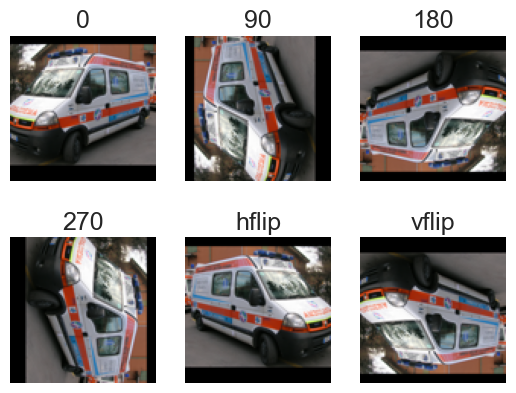

In [7]:
def rotate_by_class_id(img, label):
    if label<4:
        return np.rot90(img, k=label)
    if label==4: #hflip
        return img[:,::-1,:]
    if label==5: #vflip
        return img[::-1,:,:]
    raise ValueError

plt.figure()
for label in range(len(rot_classes)):
    plt.subplot(2,3,1+label)
    plt.title(rot_classes[label])
    plt.imshow(rotate_by_class_id(X_train[1],label))
    plt.axis('off')
plt.show();


(16, 96, 96, 3) (16,) 255


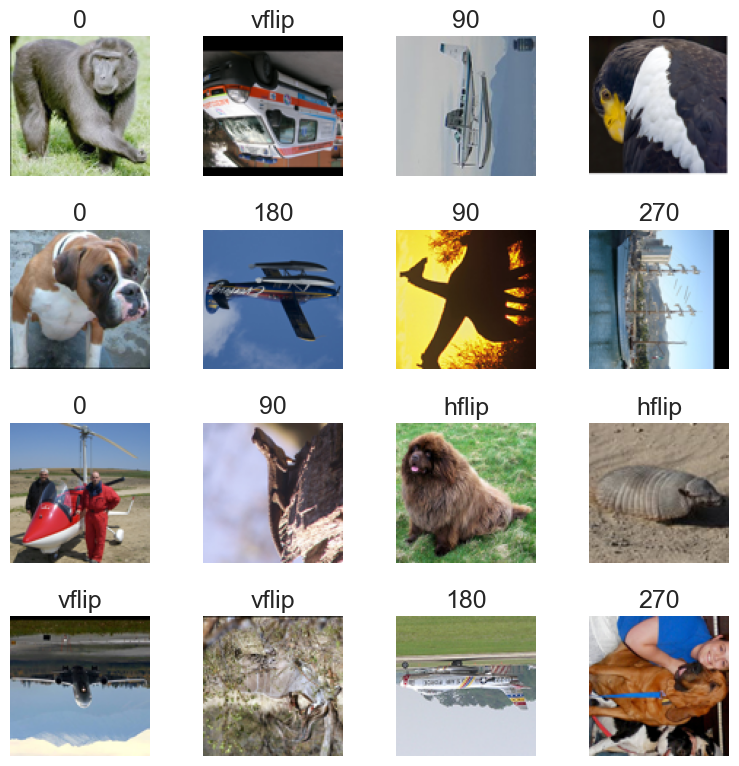

In [8]:
def rotgen(X, batch_size):
    Xb=[]
    yb=[]
    while True:
        for _x in X:
            label=random.randint(0,len(rot_classes)-1)
            img = rotate_by_class_id(_x, label)
            Xb.append(img)
            yb.append(label)
            if len(Xb)>=batch_size:
                yield np.array(Xb), np.array(yb)
                Xb=[]
                yb=[]
                
plt.figure(figsize=(8,8))
for bx,by in rotgen(X_train, 16):
    print(bx.shape, by.shape, np.max(bx))
    for i,(x,y) in enumerate(zip(bx,by)):
        plt.subplot(4,4,1+i)
        plt.axis('off')
        plt.title(rot_classes[y])
        plt.imshow(x)
    break
plt.tight_layout()
plt.show();

In [9]:
class RotGenSequence(tf.keras.utils.Sequence):

    def __init__(self, X, rot_classes, batch_size):
        self.X = X
        self.rot_classes = rot_classes
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = np.random.randint(0, len(self.rot_classes), len(batch_x))
        batch_x = [rotate_by_class_id(_x, label) for _x,label in zip(batch_x, batch_y)]

        return np.array(batch_x)/255.0, np.array(batch_y)
    
g = RotGenSequence(X_train,rot_classes,16)
for b in g:
    print([_.shape for _ in b], np.max(b[0]))
    break

[(16, 96, 96, 3), (16,)] 1.0


In [10]:
plt.figure(figsize=(10,10))
for b in g:
    for i in range(len(b[0])):
        plt.subplot(4,4,1+i)
        plt.imshow(b[0][i])
        plt.axis('off')
    print(np.max(b[0]))
    break


1.0


In [11]:
def plot_loss_acc(histories, titles):
    if type(histories)!=list:
        histories=[histories]
        titles=[titles]
    plt.figure(figsize=(15,15))

    plt.subplot(221)
    for history,title in zip(histories, titles):
        plt.plot(history.history['loss'], label=title+' train')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(223)
    for history,title in zip(histories, titles):
        plt.plot(history.history['val_loss'], label=title+' val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(222)
    for history,title in zip(histories, titles):
        plt.plot(history.history['accuracy'], label=title+' train')
    plt.title('Accuracy')
    plt.legend();
    
    plt.subplot(224)
    for history,title in zip(histories, titles):
        plt.plot(history.history['val_accuracy'], label=title+' val')
    plt.title('Accuracy')
    plt.legend();

In [12]:
epochs = 50
batch_size = 64

In [13]:
model_rot = getModelRotNet()
model_rot.summary()
history_rot = model_rot.fit(RotGenSequence(X_train,rot_classes,batch_size),
                    epochs=epochs,
                    validation_data=RotGenSequence(X_val, rot_classes, batch_size))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 8)         224       
_________________________________________________________________
average_pooling2d_3 (Average (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 32)        2336      
_________________________________________________________________
average_pooling2d_4 (Average (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
average_pooling2d_5 (Average (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 256)      

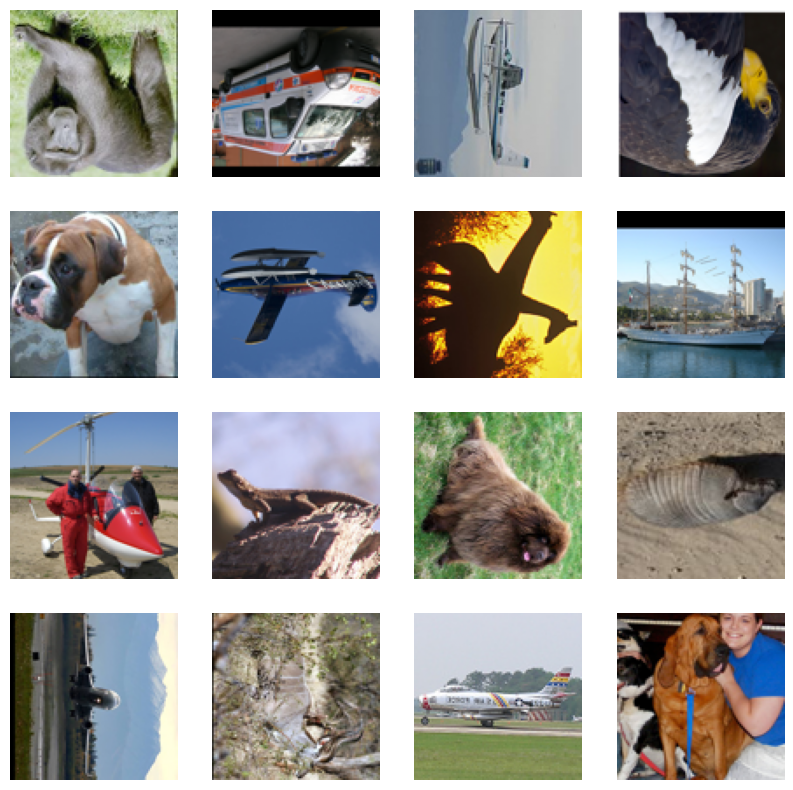

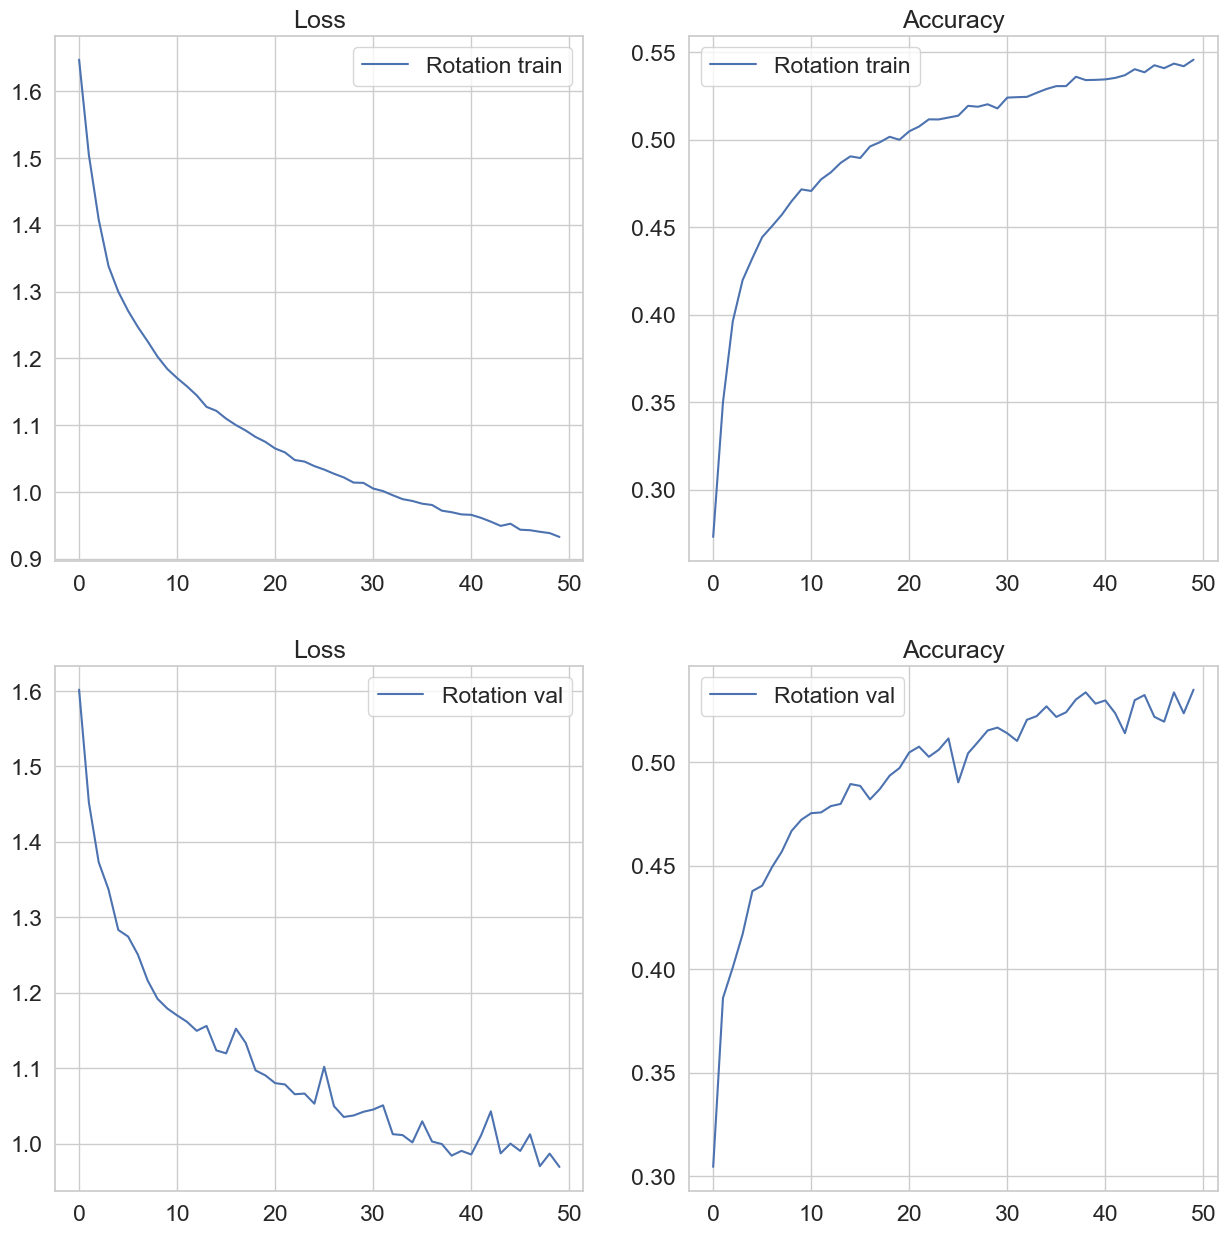

In [14]:
plot_loss_acc(history_rot, 'Rotation')
plt.show();

# Trening od zera na zbiorze train, 5k zdjęć

In [15]:
(ds_train, ds_val),info = tfds.load(
    "stl10",
    split=["train[:80%]", "train[80%:100%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print('Train:',len(ds_train))
print('Val:',len(ds_val))

Train: 4000
Val: 1000


In [16]:
class_names = info.features['label'].names

num_classes = len(class_names)
num_classes

10

In [17]:
class_names

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

2 (96, 96, 3) tf.Tensor(1, shape=(), dtype=int64) 255


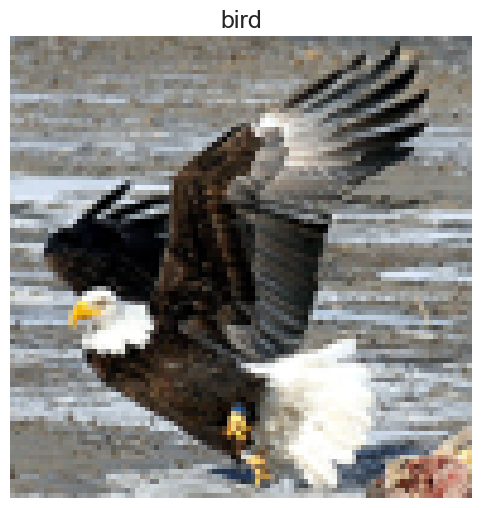

In [18]:
plt.figure(figsize=(6,6))
for i,_ in enumerate(ds_train.take(1)):
    print(len(_),_[0].shape,_[1],np.max(_[0]))
    img = (_[0])
    plt.imshow(img)
    plt.title(class_names[_[1]])
    plt.axis('off')
    plt.show();


2 (96, 96, 3) tf.Tensor(1, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(0, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(8, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(3, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(9, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(8, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(0, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(2, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(4, shape=(), dtype=int64)
2 (96, 96, 3) tf.Tensor(6, shape=(), dtype=int64)


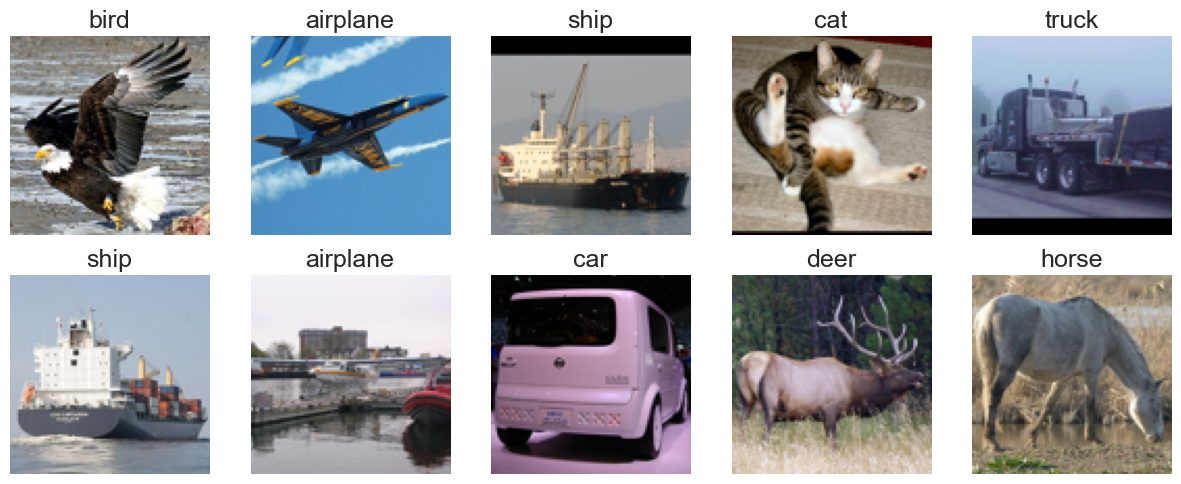

In [19]:
plt.figure(figsize=(15,15))
for i,_ in enumerate(ds_train.take(10)):
    print(len(_),_[0].shape,_[1])
    plt.subplot(5,5,i+1)
    plt.imshow(_[0])
    plt.title(class_names[_[1]])
    plt.axis('off')
plt.show()

In [20]:
#epochs = 100
#batch_size = 64
img_size = 96

size = (img_size, img_size)

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size)/255.0, label))
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size)/255.0, label))
ds_val = ds_val.batch(batch_size=batch_size, drop_remainder=True)

In [21]:
for b in ds_train:
    print(np.max(b[0]))
    break
    

1.0


In [22]:
# wzięlam jakiś zwykły model z modułu 4

model = getModel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 96, 96, 8)         224       
_________________________________________________________________
average_pooling2d_6 (Average (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        2336      
_________________________________________________________________
average_pooling2d_7 (Average (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
average_pooling2d_8 (Average (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 256)      

In [23]:
history = model.fit(ds_train, epochs=epochs, batch_size=batch_size, validation_data=(ds_val), verbose=1)

Epoch 1/50
62/62 [==============================] - 8s 119ms/step - loss: 2.1773 - accuracy: 0.1895 - val_loss: 2.0213 - val_accuracy: 0.2292
Epoch 2/50
62/62 [==============================] - 7s 118ms/step - loss: 1.9001 - accuracy: 0.2767 - val_loss: 1.8710 - val_accuracy: 0.2677
Epoch 3/50
62/62 [==============================] - 7s 119ms/step - loss: 1.7894 - accuracy: 0.3062 - val_loss: 1.7880 - val_accuracy: 0.2823
Epoch 4/50
62/62 [==============================] - 7s 118ms/step - loss: 1.7271 - accuracy: 0.3185 - val_loss: 1.7468 - val_accuracy: 0.3000
Epoch 5/50
62/62 [==============================] - 7s 118ms/step - loss: 1.6836 - accuracy: 0.3322 - val_loss: 1.7031 - val_accuracy: 0.3135
Epoch 6/50
62/62 [==============================] - 7s 118ms/step - loss: 1.6432 - accuracy: 0.3430 - val_loss: 1.6757 - val_accuracy: 0.3385
Epoch 7/50
62/62 [==============================] - 7s 119ms/step - loss: 1.6149 - accuracy: 0.3553 - val_loss: 1.6451 - val_accuracy: 0.3542
Epoch 

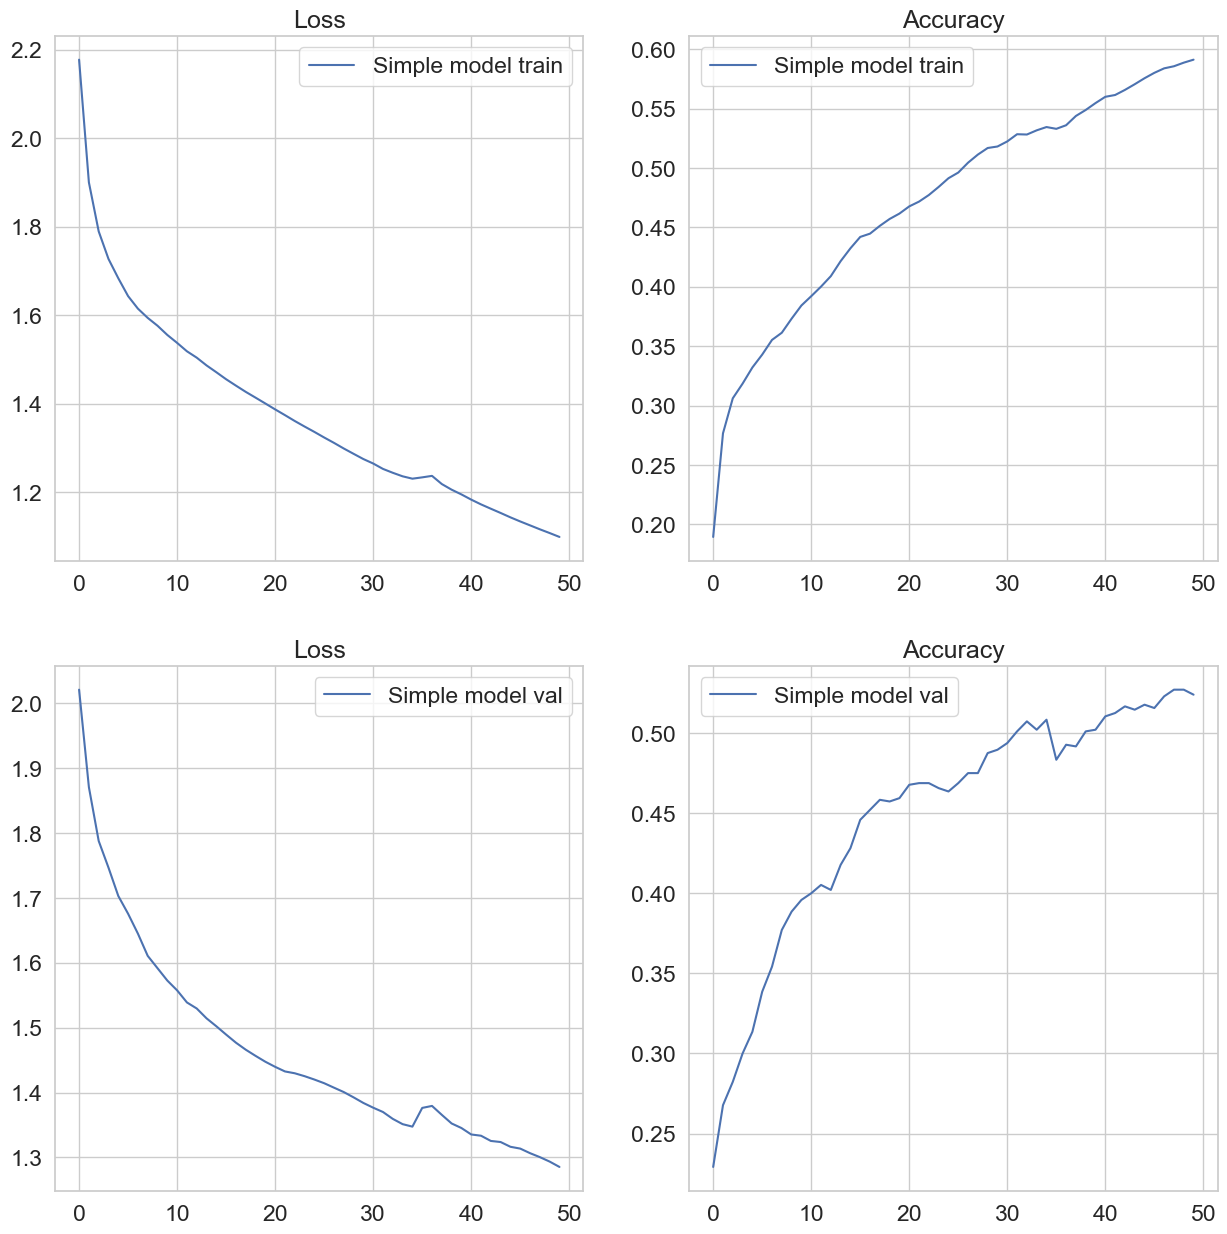

In [24]:
plot_loss_acc(history, 'Simple model') # czy o to chodziło z maila from scratch?
plt.show();

# Trening transfer learning modelu z SSL na zbiorze train, 5k zdjęć

In [25]:
#epochs = 50

model_rot.pop()
model_rot.trainable = True #zamrażamy "base_model"
model_rot.add(tf.keras.layers.Dense(10, activation='softmax'))  #nowe wyjście, na 10 klas
for l in model_rot.layers[:-1]:
    l.trainable=False
model_rot.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  #duża wartość tutaj będzie ok
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


history_t1 = model_rot.fit(ds_train,
                    batch_size=batch_size,epochs=epochs,
                    validation_data=ds_val,
                    verbose=1)

model_rot.summary()

Epoch 1/50
62/62 [==============================] - 3s 45ms/step - loss: 2.1250 - accuracy: 0.2606 - val_loss: 1.9636 - val_accuracy: 0.3521
Epoch 2/50
62/62 [==============================] - 3s 43ms/step - loss: 1.8380 - accuracy: 0.4083 - val_loss: 1.7740 - val_accuracy: 0.4167
Epoch 3/50
62/62 [==============================] - 3s 43ms/step - loss: 1.6801 - accuracy: 0.4619 - val_loss: 1.6610 - val_accuracy: 0.4500
Epoch 4/50
62/62 [==============================] - 3s 43ms/step - loss: 1.5785 - accuracy: 0.4985 - val_loss: 1.5848 - val_accuracy: 0.4729
Epoch 5/50
62/62 [==============================] - 3s 43ms/step - loss: 1.5062 - accuracy: 0.5154 - val_loss: 1.5293 - val_accuracy: 0.4823
Epoch 6/50
62/62 [==============================] - 3s 43ms/step - loss: 1.4512 - accuracy: 0.5325 - val_loss: 1.4864 - val_accuracy: 0.4990
Epoch 7/50
62/62 [==============================] - 3s 43ms/step - loss: 1.4073 - accuracy: 0.5408 - val_loss: 1.4521 - val_accuracy: 0.5104
Epoch 8/50
62

In [26]:
model_rot.trainable = True  #odmrażamy cały model
model_rot.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  #Mała wartość LR (ważne, bo to mają być małe zmiany - fine tuning)
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history_t2 = model_rot.fit(ds_train,
                    batch_size=batch_size,epochs=epochs,
                    validation_data=ds_val,
                    verbose=1)
model_rot.summary()

Epoch 1/50
62/62 [==============================] - 8s 122ms/step - loss: 0.9774 - accuracy: 0.6633 - val_loss: 1.1731 - val_accuracy: 0.5781
Epoch 2/50
62/62 [==============================] - 7s 120ms/step - loss: 0.9698 - accuracy: 0.6643 - val_loss: 1.1698 - val_accuracy: 0.5823
Epoch 3/50
62/62 [==============================] - 7s 121ms/step - loss: 0.9644 - accuracy: 0.6653 - val_loss: 1.1673 - val_accuracy: 0.5813
Epoch 4/50
62/62 [==============================] - 7s 120ms/step - loss: 0.9599 - accuracy: 0.6668 - val_loss: 1.1653 - val_accuracy: 0.5813
Epoch 5/50
62/62 [==============================] - 8s 121ms/step - loss: 0.9560 - accuracy: 0.6676 - val_loss: 1.1636 - val_accuracy: 0.5833
Epoch 6/50
62/62 [==============================] - 7s 121ms/step - loss: 0.9526 - accuracy: 0.6673 - val_loss: 1.1622 - val_accuracy: 0.5823
Epoch 7/50
62/62 [==============================] - 7s 120ms/step - loss: 0.9495 - accuracy: 0.6668 - val_loss: 1.1610 - val_accuracy: 0.5813
Epoch 

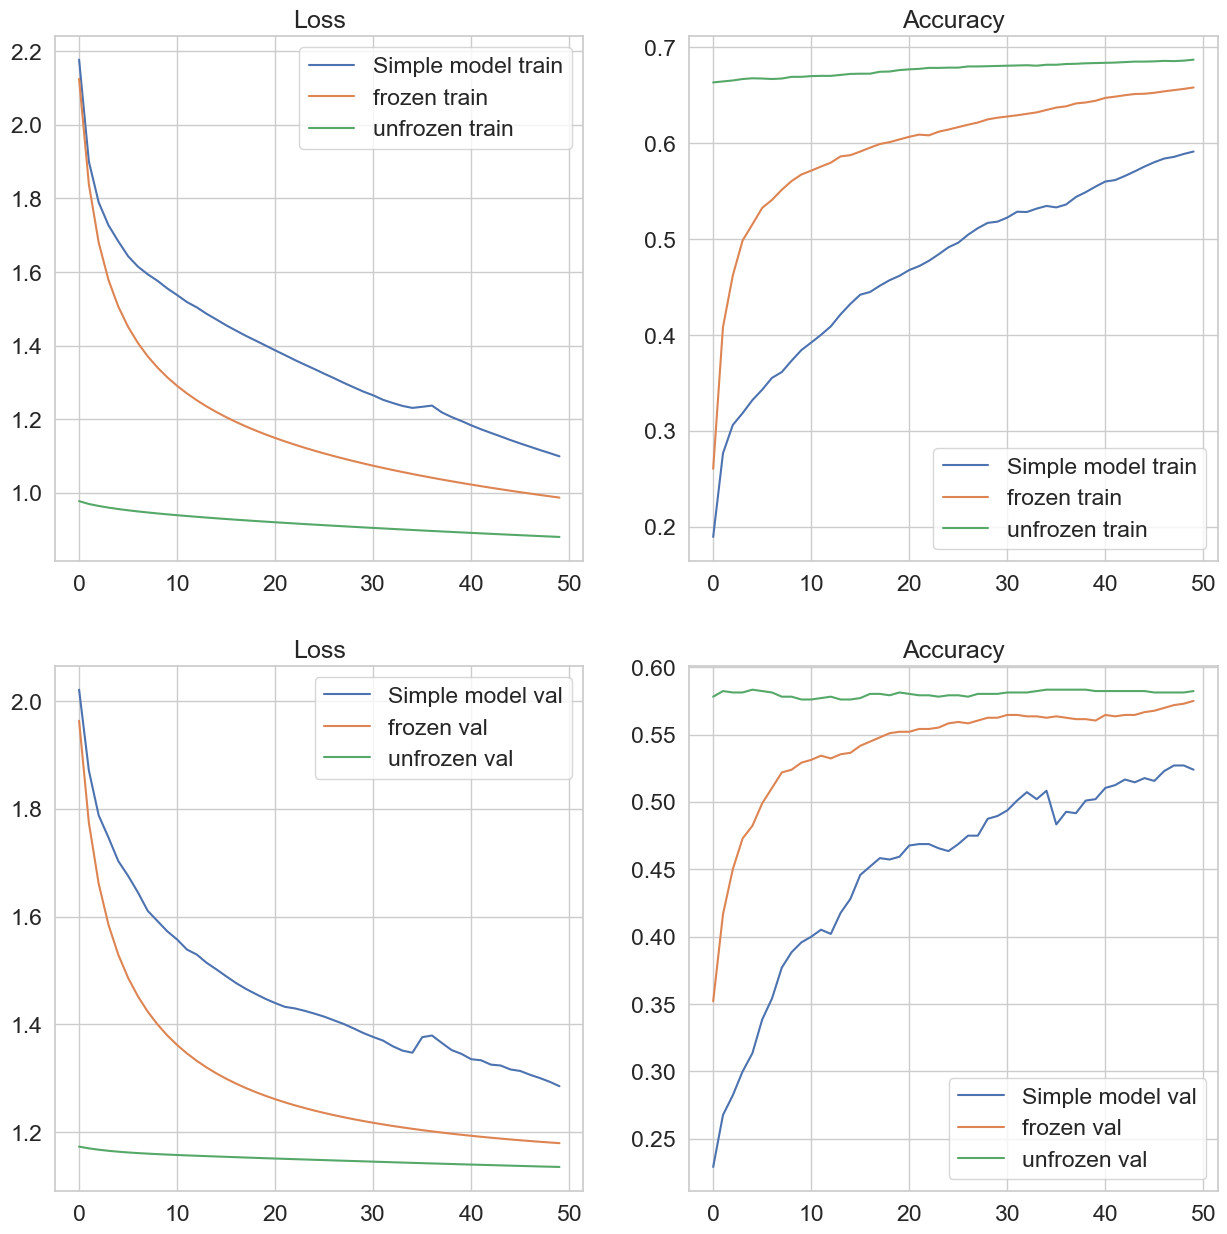

In [29]:
plot_loss_acc([history, history_t1, history_t2],['Simple model','frozen', 'unfrozen'])
plt.show();